In [7]:
# Load the packages needed for this project
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.config('spark.driver.memory','16g').getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline, classification, pipeline, evaluation, clustering
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

In [8]:
#If JVM crashed, we can use it to reset the gateway
# from py4j.java_gateway import JavaGateway
# gateway = JavaGateway()                   # connect to the JVM
# random = gateway.jvm.java.util.Random()   # create a java.util.Random instance
# number1 = random.nextInt(10)              # call the Random.nextInt method
# number2 = random.nextInt(10)
# print(number1,number2)


# Descriptive Analysis

In [9]:
#Load the dataset
book_example = spark.read.parquet('optiver-realized-volatility-prediction/book_train.parquet')

book_train = spark.read.option("header",True).csv('optiver-realized-volatility-prediction/train.csv')
book_train = book_train.select('time_id','stock_id',fn.col('target').cast("float"))
trade_example = spark.read.parquet('optiver-realized-volatility-prediction/trade_train.parquet')

In [10]:
book_example.orderBy('stock_id').show()

+-------+-----------------+----------+----------+----------+----------+---------+---------+---------+---------+--------+
|time_id|seconds_in_bucket|bid_price1|ask_price1|bid_price2|ask_price2|bid_size1|ask_size1|bid_size2|ask_size2|stock_id|
+-------+-----------------+----------+----------+----------+----------+---------+---------+---------+---------+--------+
|      5|               47| 1.0028185| 1.0032322| 1.0023013| 1.0038011|       55|        1|      100|       34|       0|
|      5|               17| 1.0014222| 1.0023013| 1.0013704| 1.0024048|        3|      100|        2|      100|       0|
|      5|               46| 1.0028185| 1.0032322| 1.0023013| 1.0038011|      155|        1|      200|       34|       0|
|      5|               11| 1.0014222| 1.0023013| 1.0013704| 1.0024048|        3|      100|        2|      100|       0|
|      5|               16| 1.0014222| 1.0023013| 1.0013704| 1.0024048|        3|      126|        2|      100|       0|
|      5|               21| 1.00

In [11]:
trade_example.orderBy('stock_id','time_id','seconds_in_bucket').show()

+-------+-----------------+---------+----+-----------+--------+
|time_id|seconds_in_bucket|    price|size|order_count|stock_id|
+-------+-----------------+---------+----+-----------+--------+
|      5|               21|1.0023013| 326|         12|       0|
|      5|               46| 1.002778| 128|          4|       0|
|      5|               50|1.0028185|  55|          1|       0|
|      5|               57|1.0031554| 121|          5|       0|
|      5|               68|1.0036459|   4|          1|       0|
|      5|               78|1.0037625| 134|          5|       0|
|      5|              122|1.0042067| 102|          3|       0|
|      5|              127|1.0045768|   1|          1|       0|
|      5|              144|  1.00437|   6|          1|       0|
|      5|              147|1.0039636| 233|          4|       0|
|      5|              177|1.0038528|   1|          1|       0|
|      5|              183|1.0039562|   2|          1|       0|
|      5|              187|1.0042665| 16

In [12]:
# Data type
book_example.printSchema()

root
 |-- time_id: short (nullable = true)
 |-- seconds_in_bucket: short (nullable = true)
 |-- bid_price1: float (nullable = true)
 |-- ask_price1: float (nullable = true)
 |-- bid_price2: float (nullable = true)
 |-- ask_price2: float (nullable = true)
 |-- bid_size1: integer (nullable = true)
 |-- ask_size1: integer (nullable = true)
 |-- bid_size2: integer (nullable = true)
 |-- ask_size2: integer (nullable = true)
 |-- stock_id: integer (nullable = true)



In [13]:
# Show the stock_id 
book_example.select("stock_id").distinct().orderBy('stock_id').show()

+--------+
|stock_id|
+--------+
|       0|
|       1|
|       2|
|       3|
|       4|
|       5|
|       6|
|       7|
|       8|
|       9|
|      10|
|      11|
|      13|
|      14|
|      15|
|      16|
|      17|
|      18|
|      19|
|      20|
+--------+
only showing top 20 rows



In [14]:
# We have 112 different stocks.
stock_count= book_example.select("stock_id").distinct().count()
# In one stock, we have 3830 time windows and each of them is limited in a ten minutes scale.
time_id_count= book_example.select("time_id").distinct().count()
# One time id means an order or trade happened in an unknown 10 minutes scale in the stock market.
#plt.scatter(book_example11.select('seconds_in_bucket').toPandas())

In [15]:
# Wap 1
book_example= book_example.withColumn('wap',(fn.col('bid_price1')*fn.col('ask_size1')+fn.col('ask_price1')*fn.col('bid_size1'))/\
                           (fn.col('bid_size1')+fn.col('ask_size1')))
# Wap 2
book_example= book_example.withColumn('wap2',(fn.col('bid_price2')*fn.col('ask_size2')+fn.col('ask_price2')*fn.col('bid_size2'))/\
                           (fn.col('bid_size2')+fn.col('ask_size2')))

In [16]:
# Calculate the log return of each stock by window function
from pyspark.sql import Window
def log_return(list_stock_prices):
    log_return1 = fn.log(fn.col('wap'))
    log_return2 = fn.lag(fn.col('log_return1')).over(Window.partitionBy("stock_id").orderBy('seconds_in_bucket'))
    list_stock_prices = list_stock_prices.withColumn('log_return1',log_return1) 
    list_stock_prices = list_stock_prices.withColumn('log_return2',log_return2) 
    list_stock_prices= list_stock_prices.withColumn('log_return',fn.col('log_return1')-fn.col('log_return2'))    
    return list_stock_prices
example = log_return(book_example)

In [17]:
def log_return_w2(list_stock_prices):
    log_return3 = fn.log(fn.col('wap2'))
    log_return4 = fn.lag(fn.col('log_return3')).over(Window.partitionBy("stock_id").orderBy('seconds_in_bucket'))
    list_stock_prices = list_stock_prices.withColumn('log_return3',log_return3) 
    list_stock_prices = list_stock_prices.withColumn('log_return4',log_return4) 
    list_stock_prices= list_stock_prices.withColumn('log_return_w2',fn.col('log_return3')-fn.col('log_return4'))    
    return list_stock_prices
example = log_return_w2(example)

In [18]:
# Calculate the volatility in past 10 mins 
example_pt = example.groupBy('stock_id','time_id').agg(fn.sum(fn.col('log_return')**2).alias('past_target')).orderBy('stock_id','time_id')

In [19]:
# Take example form the large dataset
example_0_1= example.where((fn.col('stock_id') == 0) | (fn.col('stock_id') == 1))
example_0_1=example_0_1.drop('log_return1','log_return2').orderBy('stock_id','seconds_in_bucket')

In [20]:
# Extract distinct time_id (There are the same time windows in all datasets of 127 stocks)
example_0_1.registerTempTable('book_spark_example')
time_id_index= spark.sql('select time_id from book_spark_example').dropDuplicates().\
                       select('time_id')

## Visualization

In [22]:
book_train = spark.read.parquet('optiver-realized-volatility-prediction/book_train.parquet/stock_id=0')
book_train_timeid5 = book_train[book_train["time_id"]==5]
#book_test.show(10)
samples = ["bid_price1","bid_price2","ask_price1","ask_price2"]
book_train_df=book_train_timeid5.toPandas()

In [24]:
trade_train = spark.read.parquet('optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0')
trade_train = trade_train[trade_train["time_id"]==5]
#trade_train.show(5)
trade_train_df=trade_train.toPandas()

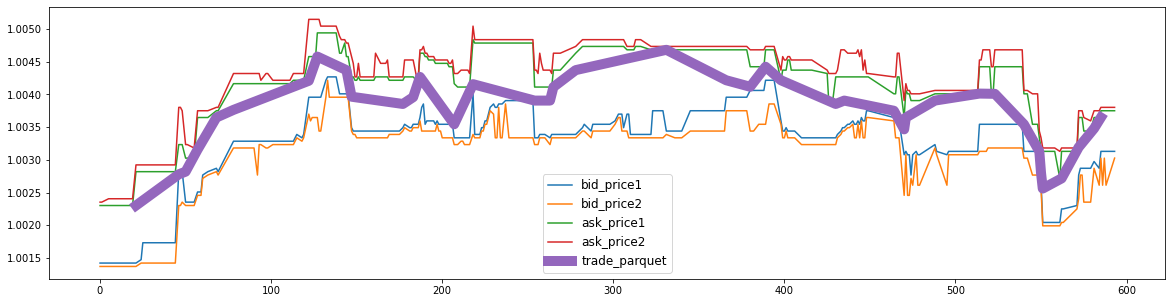

In [26]:
plt.figure(figsize=(20,5))
for num,a in enumerate(samples):
    plt.plot(book_train_df["seconds_in_bucket"],book_train_df[a],label=a)   
plt.plot(trade_train_df["seconds_in_bucket"],trade_train_df["price"],label="trade_parquet",lw=10)
plt.legend(fontsize=12)

In [32]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

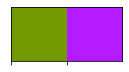

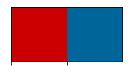

In [33]:
# colors 
mycolors = ['#739900', '#b31aff']
bidask_color = ['#cc0000', '#006699']
sns.palplot(mycolors)
sns.palplot(bidask_color)

In [34]:
# stock_id & time_id data
#book_train = spark.read.parquet('optiver-realized-volatility-prediction/book_train.parquet/stock_id=0')
book_train_timeid5 = book_train[book_train["time_id"]==5]
book_train_timeid16 = book_train[book_train["time_id"]==16]

In [35]:
#stockid_0-timeid_5
# Wap 1
book_train_stock0_timeid5= book_train_timeid5.withColumn('wap1',(fn.col('bid_price1')*fn.col('ask_size1')+fn.col('ask_price1')*fn.col('bid_size1'))/\
                           (fn.col('bid_size1')+fn.col('ask_size1')))
# Wap 2
book_train_stock0_timeid5= book_train_stock0_timeid5.withColumn('wap2',(fn.col('bid_price2')*fn.col('ask_size2')+fn.col('ask_price2')*fn.col('bid_size2'))/\
                           (fn.col('bid_size2')+fn.col('ask_size2')))
#stockid_0-timeid_16
# Wap 1
book_train_stock0_timeid16= book_train_timeid16.withColumn('wap1',(fn.col('bid_price1')*fn.col('ask_size1')+fn.col('ask_price1')*fn.col('bid_size1'))/\
                           (fn.col('bid_size1')+fn.col('ask_size1')))
# Wap 2
book_train_stock0_timeid16= book_train_stock0_timeid16.withColumn('wap2',(fn.col('bid_price2')*fn.col('ask_size2')+fn.col('ask_price2')*fn.col('bid_size2'))/\
                           (fn.col('bid_size2')+fn.col('ask_size2')))

In [36]:
book_0_time_5=book_train_stock0_timeid5.toPandas()
book_0_time_16=book_train_stock0_timeid16.toPandas()

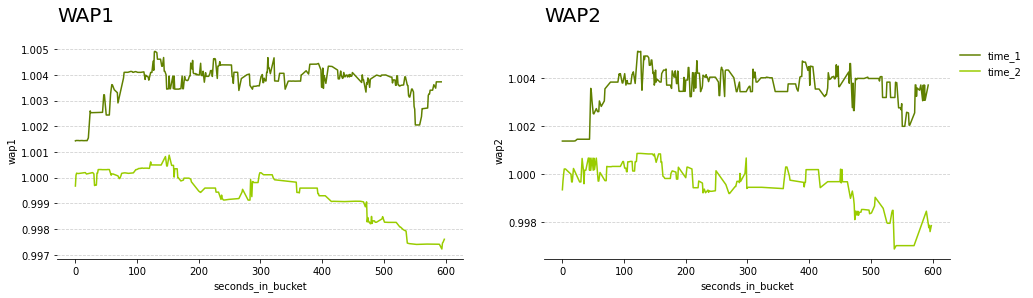

In [37]:
book_0_list = [book_0_time_5, book_0_time_16]
colors_0 = ['#608000', '#99cc00', '#d2ff4d']


fig, axes = plt.subplots(figsize = (16, 4), ncols = 2)
for i, dat in enumerate(book_0_list):
    sns.lineplot(data = dat, x = 'seconds_in_bucket', y = 'wap1', label = str('time_')+str(i+1), ax = axes[0], 
                 legend = None, color = colors_0[i])
    
for i, dat in enumerate(book_0_list):
    sns.lineplot(data = dat, x = 'seconds_in_bucket', y = 'wap2', label = str('time_')+str(i+1), ax = axes[1],
                color = colors_0[i])
for i in ['left', 'right', 'top']:
    axes[0].spines[i].set_visible(False)
    axes[1].spines[i].set_visible(False)
    
axes[0].grid(axis='y', linestyle='--', alpha = 0.6)
axes[1].grid(axis='y', linestyle='--', alpha = 0.6)
axes[1].legend(bbox_to_anchor = (0.7, 0.5, 0.5, 0.5),frameon = False)


axes[0].set_title('WAP1', fontsize = 20, pad = 20, loc = 'left')
axes[1].set_title('WAP2', fontsize = 20, pad = 20, loc = 'left')
plt.show()

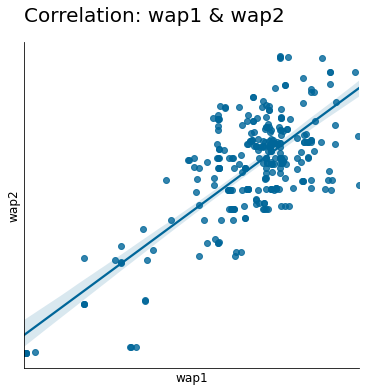

In [38]:
plt.figure(figsize = (6, 6))
ax = sns.regplot(data = book_0_time_5, x = 'wap1', y = 'wap2', color = bidask_color[1])

for i in ['right','top']:
    ax.spines[i].set_visible(False)
    ax.spines[i].set_visible(False)

ax.set_xlabel('wap1', fontsize = 12)
ax.set_ylabel('wap2', fontsize = 12)
plt.xticks([]); plt.yticks([])
plt.title('Correlation: wap1 & wap2', fontsize = 20, loc = 'left', pad = 20)
plt.show()


In [41]:
book_train43 = spark.read.parquet('optiver-realized-volatility-prediction/book_train.parquet/stock_id=43')
book_train43_timeid5 = book_train43[book_train43["time_id"]==5]
book_train43_timeid16 = book_train43[book_train43["time_id"]==16]

In [42]:
#stockid_43-timeid_5
# Wap 1
book_train_stock43_timeid5= book_train43_timeid5.withColumn('wap1',(fn.col('bid_price1')*fn.col('ask_size1')+fn.col('ask_price1')*fn.col('bid_size1'))/\
                           (fn.col('bid_size1')+fn.col('ask_size1')))
# Wap 2
book_train_stock43_timeid5= book_train_stock43_timeid5.withColumn('wap2',(fn.col('bid_price2')*fn.col('ask_size2')+fn.col('ask_price2')*fn.col('bid_size2'))/\
                           (fn.col('bid_size2')+fn.col('ask_size2')))
#stockid_43-timeid_16
# Wap 1
book_train_stock43_timeid16= book_train43_timeid16.withColumn('wap1',(fn.col('bid_price1')*fn.col('ask_size1')+fn.col('ask_price1')*fn.col('bid_size1'))/\
                           (fn.col('bid_size1')+fn.col('ask_size1')))
# Wap 2
book_train_stock43_timeid16= book_train_stock43_timeid16.withColumn('wap2',(fn.col('bid_price2')*fn.col('ask_size2')+fn.col('ask_price2')*fn.col('bid_size2'))/\
                           (fn.col('bid_size2')+fn.col('ask_size2')))

In [45]:
book_43_time_5=book_train_stock43_timeid5.toPandas()
book_43_time_16=book_train_stock43_timeid16.toPandas()

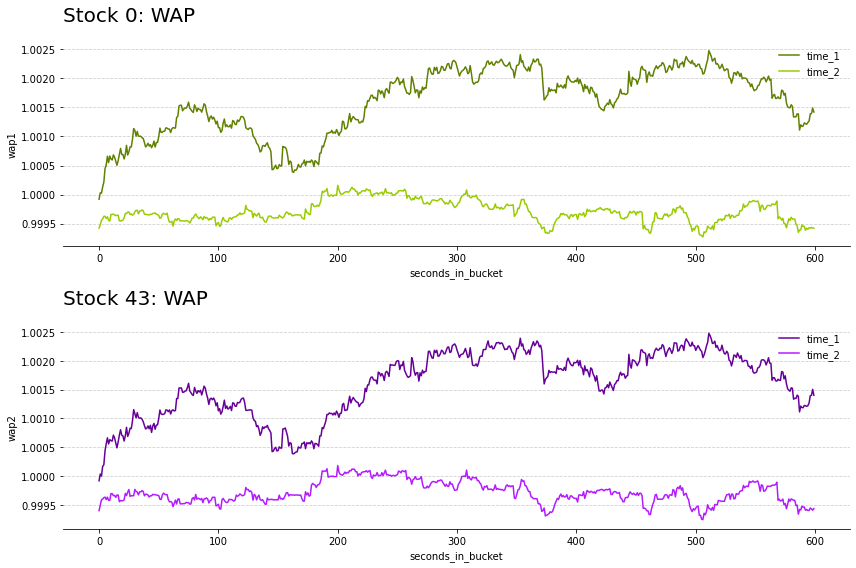

In [48]:
book_0_list = [book_0_time_5, book_0_time_16]
book_43_list = [book_43_time_5, book_43_time_16]
colors_43 = ['#660099', '#b31aff', '#eeccff']

fig, axes = plt.subplots(figsize = (12, 8), nrows = 2)
for i, dat in enumerate(book_0_list):
    sns.lineplot(data = dat, x = 'seconds_in_bucket', y = 'wap1', label = str('time_')+str(i+1), ax = axes[0]
                 , color = colors_0[i])
    
for i, dat in enumerate(book_43_list):
    sns.lineplot(data = dat, x = 'seconds_in_bucket', y = 'wap2', label = str('time_')+str(i+1), ax = axes[1], color = colors_43[i])
   
for i in ['left', 'right', 'top']:
    axes[0].spines[i].set_visible(False)
    axes[1].spines[i].set_visible(False)
    
axes[0].grid(axis='y', linestyle='--', alpha = 0.6)
axes[1].grid(axis='y', linestyle='--', alpha = 0.6)

axes[0].legend(frameon = False)
axes[1].legend(frameon = False)


axes[0].set_title('Stock 0: WAP', fontsize = 20, pad = 20, loc = 'left')
axes[1].set_title('Stock 43: WAP', fontsize = 20, pad = 20, loc = 'left')
plt.tight_layout()
plt.show()

I've used only book data to understand and visualize data. Now let's use trade data to get more interpretations. Each file in trade data has those columns.

In [59]:
# define trade data
trade_train0 = spark.read.parquet('optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0')
trade0_time_5 = trade_train0[trade_train0["time_id"]==5]
trade0_time_16 = trade_train0[trade_train0['time_id']==16]

trade_train43 = spark.read.parquet('optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0')
trade43_time_5 = trade_train43[trade_train43['time_id'] == 5]
trade43_time_16 = trade_train43[trade_train43['time_id']==16]

trade0_time_5=trade0_time_5.toPandas()
trade0_time_16=trade0_time_16.toPandas()

trade43_time_5=trade43_time_5.toPandas()
trade43_time_16=trade43_time_16.toPandas()

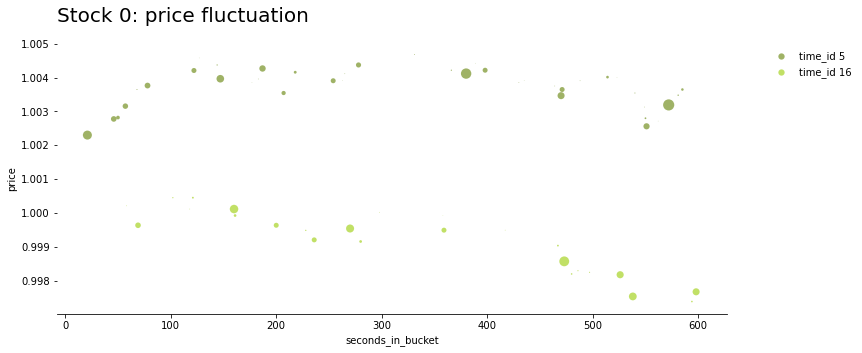

In [63]:
def plot_price_fluc(data1, data2, stock_id, color):
    plt.figure(figsize = (12, 5))
    ax = plt.subplot(1, 1, 1)
    sns.scatterplot(data = data1, x = 'seconds_in_bucket', y = 'price', s = data1['size']/4
                , color = color[0], label = 'time_id 5', alpha = 0.6)
    sns.scatterplot(data = data2, x = 'seconds_in_bucket', y = 'price', s = data2['size']/4
                , color = color[1], label = 'time_id 16', alpha = 0.6)


    for i in ['left', 'right', 'top']:
        ax.spines[i].set_visible(False)
    
    legend = plt.legend(frameon = False, bbox_to_anchor = (0.7, 0.5, 0.5, 0.5), scatterpoints = 1)
    legend.legendHandles[0]._sizes = [40]
    legend.legendHandles[1]._sizes = [40]
    plt.title(f'Stock {stock_id}: price fluctuation', fontsize = 20, pad = 20, loc = 'left')
    plt.show()
    
    
plot_price_fluc(trade0_time_5, trade0_time_16, 0, colors_0)

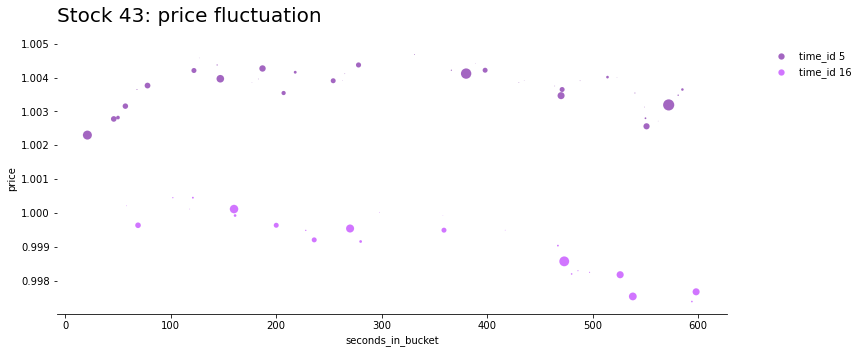

In [64]:
plot_price_fluc(trade43_time_5, trade43_time_16, 43, colors_43)

## Features Engineering

In [146]:
example_0_1 = example_0_1.withColumn('wap3',(fn.col('bid_price1')*fn.col('ask_size2')+fn.col('ask_price1')*fn.col('bid_size2'))/\
                           (fn.col('bid_size1')+fn.col('ask_size1')))
example_0_1 = example_0_1.withColumn('wap4',(fn.col('bid_price2')*fn.col('ask_size1')+fn.col('ask_price2')*fn.col('bid_size1'))/\
                           (fn.col('bid_size2')+fn.col('ask_size2')))
example_0_1 = example_0_1.withColumn('bidask1',fn.col('bid_price1')*fn.col('ask_price1'))
example_0_1 = example_0_1.withColumn('bidask2',fn.col('bid_price2')*fn.col('ask_price2'))
example_0_1 = example_0_1.withColumn('bidask3',fn.col('bid_price1')*fn.col('ask_price2'))
example_0_1 = example_0_1.withColumn('bidask4',fn.col('bid_price2')*fn.col('ask_price1'))

example_0_1 = example_0_1.withColumn('diff1',fn.col('bid_price1')*fn.col('bid_size1')-fn.col('bid_price2')*fn.col('bid_size2'))
example_0_1 = example_0_1.withColumn('diff2',fn.col('bid_price1')*fn.col('ask_size1')-fn.col('bid_price2')*fn.col('ask_size2'))
example_0_1 = example_0_1.withColumn('diff3',fn.col('ask_price1')*fn.col('ask_size1')-fn.col('ask_price2')*fn.col('ask_size2'))
example_0_1 = example_0_1.withColumn('diff4',fn.col('ask_price1')*fn.col('bid_size1')-fn.col('ask_price2')*fn.col('bid_size2'))

## Splits

In [233]:
training_df_index, validation_df_index, testing_df_index = time_id_index.randomSplit([0.6, 0.3, 0.1], seed=0)
# Index match
training_df_index = [int(row['time_id']) for row in training_df_index.collect()]
validation_df_index = [int(row['time_id']) for row in validation_df_index.collect()]
testing_df_index = [int(row['time_id']) for row in testing_df_index.collect()]

training_df = example_0_1.where(fn.col('time_id').isin(training_df_index))
validation_df = example_0_1.where(fn.col('time_id').isin(validation_df_index))
testing_df = example_0_1.where(fn.col('time_id').isin(testing_df_index))

In [234]:
training_df= training_df.limit(60)
validation_df = validation_df.limit(30)
testing_df = testing_df.limit(10)

In [237]:
book_train_0 = book_train.select('*').where("stock_id==0 or stock_id ==1")

features = ['seconds_in_bucket','bid_price1','ask_price1','bid_price2',\
           'ask_price2','bid_size1','bid_size2','ask_size2','wap','log_return','wap2','log_return_w2',\
            'wap3','wap4','bidask1','bidask2','bidask3','bidask4']

expressions = [fn.avg(col).alias(col) for col in features]

train_feature= training_df.groupBy('stock_id','time_id').agg(*expressions).orderBy('stock_id','time_id')

valid_feature = validation_df.groupBy('stock_id','time_id').agg(*expressions).orderBy('stock_id','time_id')

test_feature = testing_df.groupBy('stock_id','time_id').agg(*expressions).orderBy('stock_id','time_id')

train_0_1 = train_feature.join(book_train_0, on = ['stock_id','time_id'])
valid_0_1 = valid_feature.join(book_train_0, on = ['stock_id','time_id'])
test_0_1 = test_feature.join(book_train_0, on = ['stock_id','time_id'])

In [238]:
feature_list = ['seconds_in_bucket','bid_price1','ask_price1','bid_price2',\
            'ask_price2','bid_size1','bid_size2','ask_size2','wap','log_return','wap2','log_return_w2',\
                                          'wap3','wap4','bidask1','bidask2','bidask3','bidask4']

# kmeans = clustering.KMeans(k=10, featuresCol='features_2', predictionCol='clustering')

# featurize = Pipeline(stages=[
#     feature.VectorAssembler(inputCols=feature_list,
#                            outputCol='features_1'),
#     feature.StandardScaler(withMean=True,
#                            inputCol='features_1', outputCol='features_2'),
#     kmeans,
#     feature.OneHotEncoder(inputCols=['time_id','stock_id','clustering'],
#                         outputCols=['time_d','stock_d','clustering_d']),
#     feature.VectorAssembler(inputCols=['time_d','stock_d','clustering_d','features_2'],
#                            outputCol='features')
# ]).fit(train_0_1)

featurize = Pipeline(stages=[
    feature.VectorAssembler(inputCols=feature_list,
                           outputCol='features_1'),
    feature.StandardScaler(withMean=True,
                           inputCol='features_1', outputCol='features_2'),
    feature.OneHotEncoder(inputCols=['time_id','stock_id'],
                        outputCols=['time_d','stock_d']),
    feature.VectorAssembler(inputCols=['time_d','stock_d','features_2'],
                           outputCol='features')
]).fit(train_0_1)

training_df = featurize.transform(train_0_1)
validation_df = featurize.transform(valid_0_1)
testing_df =featurize.transform(test_0_1)

## RMSPE

In [239]:
# Rmspe
expr = fn.sqrt(fn.mean((((fn.col('target')-fn.col('prediction'))/fn.col('target')))**2))

## Linear Regression

In [240]:
# Linear model
feature_list_1 = ['seconds_in_bucket','bid_price1','ask_price1','bid_price2',\
            'ask_price2','bid_size1','bid_size2','ask_size2','wap','log_return','wap2','log_return_w2',\
                                          'wap3','wap4','bidask1','bidask2','bidask3','bidask4']

# kmeans1 = clustering.KMeans(k=10, featuresCol='features_2', predictionCol='clustering')
# featurize = Pipeline(stages=[
# feature.VectorAssembler(inputCols=feature_list_1,
#                            outputCol='features_1'),
# feature.StandardScaler(withMean=True,
#                            inputCol='features_1', outputCol='features_2'),
# kmeans1,
# feature.VectorAssembler(inputCols=['time_id','stock_id','clustering','features_2'],
#                            outputCol='features')
# ]).fit(train_0_1)

featurize = Pipeline(stages=[
feature.VectorAssembler(inputCols=feature_list_1,
                           outputCol='features_1'),
feature.StandardScaler(withMean=True,
                           inputCol='features_1', outputCol='features_2'),
feature.VectorAssembler(inputCols=['time_id','stock_id','features_2'],
                           outputCol='features')
]).fit(train_0_1)

features_df = featurize.transform(train_0_1)
validation_df_tf=featurize.transform(valid_0_1)
lr_estimator = regression.LinearRegression(featuresCol='features',labelCol='target')
lr_estimator = lr_estimator.fit(features_df)
prediction_m= lr_estimator.transform(validation_df_tf)
predictions_df = prediction_m.select('stock_id','time_id','target','prediction').orderBy('stock_id','time_id')

In [241]:
# RMSPE
rmspe = predictions_df.select(expr.alias('rmspe'))
rmspe.toPandas().values[0][0]

0.8128489843136231

In [242]:
# R2 and AdjR2
print(lr_estimator.summary.r2)
print(lr_estimator.summary.r2adj)

0.7480107144269297
0.6187854397740731


## Backwise

In [243]:
feature_list_1 = ['seconds_in_bucket','bid_price1','ask_price1','bid_price2',\
            'ask_price2','bid_size1','bid_size2','ask_size2','wap','log_return','wap2','log_return_w2',\
                                          'wap3','wap4','bidask1','bidask2','bidask3','bidask4']
RMSPE = []
for i in range(len(feature_list_1)):
#for i in range(6,10):
    feature_list1 = feature_list_1[:i+2]
    #kmeans1 = clustering.KMeans(k=10, featuresCol='features_2', predictionCol='clustering')
    featurize = Pipeline(stages=[
    feature.VectorAssembler(inputCols=feature_list1,
                           outputCol='features_1'),
    feature.StandardScaler(withMean=True,
                           inputCol='features_1', outputCol='features_2'),
    #kmeans1,
    feature.VectorAssembler(inputCols=['time_id','stock_id','features_2'],#,'clustering'
                           outputCol='features')
]).fit(train_0_1)
    features_df = featurize.transform(train_0_1)
    validation_df_tf=featurize.transform(valid_0_1)
    lr_estimator = regression.LinearRegression(featuresCol='features',labelCol='target')
    lr_estimator = lr_estimator.fit(features_df)
    prediction_m= lr_estimator.transform(validation_df_tf)
    predictions_df = prediction_m.select('stock_id','time_id','target','prediction').orderBy('stock_id','time_id')
    rmspe = predictions_df.select(expr.alias('rmspe'))
    rmspe = rmspe.toPandas().values[0][0]
    print(rmspe)

0.9367669114365671
0.7600997210836541
0.7934699376195473
0.7970589579191091
0.7965683199278586
0.7936704949861965
0.79061839066266
0.6983590975663836
0.9274949960102629
0.8942349325944234
1.0187179428657087
1.024102015135161
0.9262111902189477
0.9232849619847209
0.8343856079878664
0.8225758828099663
0.8132309855658205
0.8129056752613757


## GBRT

In [232]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import feature, regression, evaluation, Pipeline
evaluator = evaluation.RegressionEvaluator(labelCol='target', metricName='r2')
gbr = GBTRegressor(labelCol='target',seed=0)
gbr_pipe = Pipeline(stages=[featurize ,gbr]).fit(train_0_1)
R2_gbr= evaluator.evaluate(gbr_pipe.transform(valid_0_1))
print("Performance of GBR: ", R2_gbr)
prediction_gbr= gbr_pipe.transform(valid_0_1)
predictions_gbr = prediction_gbr.select('stock_id','time_id','target','prediction').orderBy('stock_id','time_id')
rmspe = predictions_gbr.select(expr.alias('rmspe'))
rmspe = rmspe.toPandas().values[0][0]
print(rmspe)

Performance of GBR:  0.417301407336815
0.48195609438149634


In [209]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import feature, regression, evaluation, Pipeline
evaluator = evaluation.RegressionEvaluator(labelCol='target', metricName='r2')
gbr = GBTRegressor(labelCol='target',seed=0)
gbr1 = GBTRegressor(labelCol='target',maxDepth=3, maxBins=20,seed=0)
gbr2 = GBTRegressor(labelCol='target',maxDepth=4, maxBins=30,seed=0)
gbr3 = GBTRegressor(labelCol='target',maxDepth=5, maxBins=40,seed=0)
gbr4 = GBTRegressor(labelCol='target',maxDepth=6, maxBins=50,seed=0)
gbr_pipe = Pipeline(stages=[featurize ,gbr]).fit(train_0_1)
gbr_pipe1 = Pipeline(stages=[featurize ,gbr1]).fit(train_0_1)
gbr_pipe2 = Pipeline(stages=[featurize ,gbr2]).fit(train_0_1)
gbr_pipe3 = Pipeline(stages=[featurize ,gbr3]).fit(train_0_1)
gbr_pipe4 = Pipeline(stages=[featurize ,gbr4]).fit(train_0_1)

R2_gbr= evaluator.evaluate(gbr_pipe.transform(valid_0_1))
R2_gbr1= evaluator.evaluate(gbr_pipe1.transform(valid_0_1))
R2_gbr2= evaluator.evaluate(gbr_pipe2.transform(valid_0_1))
R2_gbr3= evaluator.evaluate(gbr_pipe3.transform(valid_0_1))
R2_gbr4= evaluator.evaluate(gbr_pipe4.transform(valid_0_1))

In [210]:
print("Performance of GBR: ", R2_gbr)
print("Performance of GBR1: ", R2_gbr1)
print("Performance of GBR2: ", R2_gbr2)
print("Performance of GBR3: ", R2_gbr3)
print("Performance of GBR4: ", R2_gbr4)

Performance of GBR:  -0.17757728919147664
Performance of GBR1:  0.4094762057426914
Performance of GBR2:  0.21568295042715935
Performance of GBR3:  0.1092460264811187
Performance of GBR4:  -0.012961153159018357


In [211]:
prediction_gbr= gbr_pipe.transform(valid_0_1)
predictions_gbr = prediction_gbr.select('stock_id','time_id','target','prediction').orderBy('stock_id','time_id')
prediction_gbr1= gbr_pipe1.transform(valid_0_1)
predictions_gbr1 = prediction_gbr1.select('stock_id','time_id','target','prediction').orderBy('stock_id','time_id')
prediction_gbr2= gbr_pipe2.transform(valid_0_1)
predictions_gbr2 = prediction_gbr2.select('stock_id','time_id','target','prediction').orderBy('stock_id','time_id')
prediction_gbr3= gbr_pipe3.transform(valid_0_1)
predictions_gbr3 = prediction_gbr3.select('stock_id','time_id','target','prediction').orderBy('stock_id','time_id')
prediction_gbr4= gbr_pipe4.transform(valid_0_1)
predictions_gbr5 = prediction_gbr4.select('stock_id','time_id','target','prediction').orderBy('stock_id','time_id')

In [212]:
rmspe = predictions_gbr.select(expr.alias('rmspe'))
rmspe = rmspe.toPandas().values[0][0]
print(rmspe)
rmspe1 = predictions_gbr1.select(expr.alias('rmspe1'))
rmspe1 = rmspe1.toPandas().values[0][0]
print(rmspe1)
rmspe2 = predictions_gbr2.select(expr.alias('rmspe2'))
rmspe2 = rmspe2.toPandas().values[0][0]
print(rmspe2)
rmspe3 = predictions_gbr3.select(expr.alias('rmspe3'))
rmspe3 = rmspe3.toPandas().values[0][0]
print(rmspe3)
rmspe4 = prediction_gbr4.select(expr.alias('rmspe4'))
rmspe4 = rmspe4.toPandas().values[0][0]
print(rmspe4)

0.6740654030396105
0.545760293471958
0.6084862145361607
0.6372162565647741
0.6656638910321898


## RF

In [164]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
rf1 = RandomForestRegressor(labelCol='target',maxDepth=2, maxBins=60, seed=0)
pipe_rf1 = Pipeline(stages=[featurize ,rf1]).fit(train_0_1)
rf2 = RandomForestRegressor(labelCol='target',maxDepth=3, maxBins=40, seed=0)
pipe_rf2 = Pipeline(stages=[featurize ,rf2]).fit(train_0_1)
rf3 = RandomForestRegressor(labelCol='target',maxDepth=6, maxBins=20, seed=0)
pipe_rf3 = Pipeline(stages=[featurize ,rf3]).fit(train_0_1)

In [168]:
prediction_rf1= pipe_rf1.transform(valid_0_1)
predictions_rf1 = prediction_rf1.select('stock_id','time_id','target','prediction').orderBy('stock_id','time_id')
prediction_rf2= pipe_rf2.transform(valid_0_1)
predictions_rf2 = prediction_rf2.select('stock_id','time_id','target','prediction').orderBy('stock_id','time_id')
prediction_rf3= pipe_rf3.transform(valid_0_1)
predictions_rf3 = prediction_rf3.select('stock_id','time_id','target','prediction').orderBy('stock_id','time_id')

In [170]:
rmspe1 = predictions_rf1.select(expr.alias('rmspe'))
rmspe1 = rmspe1.toPandas().values[0][0]
print(rmspe1)
rmspe2 = predictions_rf2.select(expr.alias('rmspe'))
rmspe2 = rmspe2.toPandas().values[0][0]
print(rmspe2)
rmspe3 = predictions_rf3.select(expr.alias('rmspe'))
rmspe3 = rmspe3.toPandas().values[0][0]
print(rmspe3)

0.7424695795285201
0.68567811734567
0.6190719292630709


## MLP

In [134]:
from pyspark.ml.classification import LogisticRegression

layers = [
    training_df.schema["features"].metadata["ml_attr"]["num_attrs"],
    20, 10, 2
]


mlp_model1 = classification.MultilayerPerceptronClassifier(seed=0).\
    setLabelCol('target').\
    setStepSize(0.2).\
    setMaxIter(200).\
    setFeaturesCol('features').setLayers(layers).fit(training_df)

In [135]:
mlp_model1.transform(validation_df).printSchema()

root
 |-- stock_id: integer (nullable = true)
 |-- time_id: short (nullable = true)
 |-- seconds_in_bucket: double (nullable = true)
 |-- bid_price1: double (nullable = true)
 |-- ask_price1: double (nullable = true)
 |-- bid_price2: double (nullable = true)
 |-- ask_price2: double (nullable = true)
 |-- bid_size1: double (nullable = true)
 |-- bid_size2: double (nullable = true)
 |-- ask_size2: double (nullable = true)
 |-- wap: double (nullable = true)
 |-- log_return: double (nullable = true)
 |-- wap2: double (nullable = true)
 |-- log_return_w2: double (nullable = true)
 |-- wap3: double (nullable = true)
 |-- wap4: double (nullable = true)
 |-- bidask1: double (nullable = true)
 |-- bidask2: double (nullable = true)
 |-- bidask3: double (nullable = true)
 |-- bidask4: double (nullable = true)
 |-- target: float (nullable = true)
 |-- features_1: vector (nullable = true)
 |-- features_2: vector (nullable = true)
 |-- clustering: integer (nullable = false)
 |-- time_d: vector (null

In [136]:
a= mlp_model1.transform(validation_df)


In [137]:
rmspe = a.select(expr.alias('rmspe'))
rmspe = rmspe.toPandas().values[0][0]
print(rmspe)

1.0


In [138]:
a.select('target','prediction').show()

+-----------+----------+
|     target|prediction|
+-----------+----------+
|0.001747216|       0.0|
|0.002182459|       0.0|
|0.002751333|       0.0|
|0.005525141|       0.0|
|0.002077241|       0.0|
|0.004870531|       0.0|
|0.001393926|       0.0|
|0.003783707|       0.0|
|0.002083402|       0.0|
|0.001691769|       0.0|
|0.002747106|       0.0|
|0.002058631|       0.0|
|0.008568275|       0.0|
|0.003597421|       0.0|
|0.002579156|       0.0|
|0.006664945|       0.0|
|0.004579577|       0.0|
|   0.003029|       0.0|
|0.001669073|       0.0|
|0.003519682|       0.0|
+-----------+----------+
only showing top 20 rows



In [139]:
# to compute AUC use the following evaluator
evaluator = evaluation.BinaryClassificationEvaluator(labelCol='target')

In [140]:
AUC1 = evaluator.evaluate(mlp_model1.transform(validation_df))